## <b>Tasks: 
* Linear Regression
* Polynomial  Reg. + GridSearch
* Try: Normalizaiton, Drop cos/sin, Drop 0~16, MAE, R2, Cross Validation(R2)

---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set Pandas Dataframe Display Scopes
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 200)  # or 1000
pd.set_option('display.max_colwidth', 0)

In [ ]:
# Demonstration data used in this excercise is already preprocessed and split into
# training, validation, and test sets

# Use wget to download the data stored in csv format.
import itertools

# Define what files to download; download all of the preprocessed data
# Note that the data are already split into Train, Validation, and Test sets.
# The predictor data are denoted with 'X', the target by 'y'
data_download = {}
data_download["window_size"] = [5, 15]
data_download["data_type"] = ["train", "valid", "test"]
data_download["predictor_or_target"] = ["X", "y"]

# Prepare the combinations of the window sizes and the data types
keys, values = zip(*data_download.items())
data_download_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
display('The kind of data to be downloaded:', data_download_combinations)

print("Downloading started...")
for data_download_param in data_download_combinations:
  file_to_download = "https://frankfurt-school-dataset.s3.eu-central-1.amazonaws.com/Sept2021/window_size_{0}_time_encoding_True/{1}_{2}_window_size_{0}_time_encoding_True.csv"\
                     .format(data_download_param["window_size"], data_download_param["predictor_or_target"], data_download_param["data_type"])

  # the actual downloading
  !wget "$file_to_download"

print("Downloading has finished")


In [ ]:
# List the directory; the downloaded file should be there. Verify this.
!ls -lh

In [3]:
# Load the data using the pandas library
# For the below demonstration, only the
#    * window_size of 5 files
#    * and only the training sets will be loaded here
# The validation and test sets can be similarly loaded.
# One can also use a similar kind of method for loading as was used for the download
# This can avoid the many lines of manual specification of the files. Manual is also fine, btw.

X_train_5 = pd.read_csv('X_train_window_size_5_time_encoding_True.csv')
X_train_15 = pd.read_csv('X_train_window_size_15_time_encoding_True.csv')
X_valid_5 = pd.read_csv('X_valid_window_size_5_time_encoding_True.csv')
X_valid_15 = pd.read_csv('X_valid_window_size_15_time_encoding_True.csv')
X_test_5 = pd.read_csv('X_test_window_size_5_time_encoding_True.csv')
X_test_15 = pd.read_csv('X_test_window_size_15_time_encoding_True.csv')
y_train_5 = pd.read_csv('y_train_window_size_5_time_encoding_True.csv')
y_train_15 = pd.read_csv('y_train_window_size_15_time_encoding_True.csv')
y_valid_5 = pd.read_csv('y_valid_window_size_5_time_encoding_True.csv')
y_valid_15 = pd.read_csv('y_valid_window_size_15_time_encoding_True.csv')
y_test_5 = pd.read_csv('y_test_window_size_5_time_encoding_True.csv')
y_test_15 = pd.read_csv('y_test_window_size_15_time_encoding_True.csv')

# Display the first 5 rows of the predictor and the target data; for a description of the content, see the text below this cell
print("X_train_5 shape:", X_train_5.shape)
print("X_valid_5 shape:", X_valid_5.shape)
print("X_test_5 shape:", X_test_5.shape)
print("y_train_5 shape:", y_train_5.shape)
print("y_valid_5 shape:", y_valid_5.shape)
print("y_test_5 shape:", y_test_5.shape)

X_train_5 shape: (91512, 41)
X_valid_5 shape: (4817, 41)
X_test_5 shape: (10704, 41)
y_train_5 shape: (91512, 1)
y_valid_5 shape: (4817, 1)
y_test_5 shape: (10704, 1)


In [ ]:
X_train_5.describe()

In [ ]:
y_test_5.describe()

# <b> 1. Libraries & Helper Functions </b>




In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline

In [5]:
##### Function to perform Cross Validation on Linear Models
def get_cv_scores(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print('CV Mean of R2: ', np.mean(scores))
    print('CV STD of R2: ', np.std(scores))

##### Function to evaluate Linear Models
def evaluate_valid(model, X_valid, y_valid, X_test, y_test):
    predictions_valid = model.predict(X_valid)
    mae_valid = mean_absolute_error(y_valid, predictions_valid)
    r2_valid = r2_score(y_valid, predictions_valid)
    print("Validation MAE:", mae_valid)
    print("Validation R2:", r2_valid)

    predictions_test = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, predictions_test)
    r2_test = r2_score(y_test, predictions_test)
    print("Test MAE:", mae_test)
    print("Test R2:", r2_test)
    
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(y_valid, predictions_valid, color='r', label='valid set', alpha=0.2)
    ax.scatter(y_test, predictions_test, color='b', label='test set', alpha=0.2)
    ax.set_title('Distributions of predicted and real Y')
    ax.set_xlabel('Actual Y')
    ax.set_ylabel('Predicted Y')
    ax.legend()
    

##### Function to normalize data
def min_max_norm(X_train_5, X_valid_5, X_test_5):
    scaler = MinMaxScaler()
    X_train_5_norm = scaler.fit_transform(X_train_5)
    X_valid_5_norm = scaler.transform(X_valid_5)
    X_test_5_norm = scaler.transform(X_test_5)
    return (X_train_5_norm, X_valid_5_norm, X_test_5_norm)

##### Function to Drop cos/sin-transformed data
def drop_cos_sin(X_train_5, X_valid_5, X_test_5):
    X_train_5_drop = X_train_5.drop(['dlvry_day_sin', 'dlvry_day_cos', 'dlvry_weekday_cos', 'dlvry_weekday_sin', 
                                     'dlvry_hour_sin', 'dlvry_hour_cos', 'lasttrade_day_sin', 'lasttrade_day_cos',
                                     'lasttrade_weekday_sin', 'lasttrade_weekday_cos', 'lasttrade_hour_sin', 'lasttrade_hour_cos'], axis=1)
    X_valid_5_drop = X_valid_5.drop(['dlvry_day_sin', 'dlvry_day_cos', 'dlvry_weekday_cos', 'dlvry_weekday_sin', 
                                     'dlvry_hour_sin', 'dlvry_hour_cos', 'lasttrade_day_sin', 'lasttrade_day_cos',
                                     'lasttrade_weekday_sin', 'lasttrade_weekday_cos', 'lasttrade_hour_sin', 'lasttrade_hour_cos'], axis=1)
    X_test_5_drop = X_test_5.drop(['dlvry_day_sin', 'dlvry_day_cos', 'dlvry_weekday_cos', 'dlvry_weekday_sin', 
                                   'dlvry_hour_sin', 'dlvry_hour_cos', 'lasttrade_day_sin', 'lasttrade_day_cos',
                                   'lasttrade_weekday_sin', 'lasttrade_weekday_cos', 'lasttrade_hour_sin', 'lasttrade_hour_cos'], axis=1)
    return (X_train_5_drop, X_valid_5_drop, X_test_5_drop)

##### Function to drop non-trading data (columns: 0~16)
def drop_first_half(X_train_5, X_valid_5, X_test_5):
    X_train_5_half = X_train_5.iloc[:,17:]
    X_valid_5_half = X_valid_5.iloc[:,17:]
    X_test_5_half = X_test_5.iloc[:,17:]
    return (X_train_5_half, X_valid_5_half, X_test_5_half)
    

# <b> 2. Linear Regression</b>

In [6]:
##### Normailze X and y to have the same scale
X_train_5_norm, X_valid_5_norm, X_test_5_norm = min_max_norm(X_train_5, X_valid_5, X_test_5)
y_train_5_norm, y_valid_5_norm, y_test_5_norm = min_max_norm(y_train_5, y_valid_5, y_test_5)

CV Mean of R2:  -0.002444375793035647
CV STD of R2:  0.011855571850614779
Validation MAE: 0.010423163294142637
Validation R2: -0.00694251426219572
Test MAE: 0.009283621909220937
Test R2: -0.004568293422968717
Independent term in the linear model:  [0.36316418]
Estimated coefficients in the linear regression:  [[ 7.28858845e-04 -4.02306390e-05 -5.92662314e-04 -1.19499748e-03
   9.42984210e-04  1.52300316e-04  2.39405108e-04  9.64521225e-05
  -3.74000799e-05  1.21296765e-04  1.18406997e-03  1.56347294e-03
  -5.86577818e-04  8.74955100e-04 -2.61012717e-05 -9.72208065e-04
   5.93326755e-05 -1.83845337e-02  3.58493130e-02  2.36028802e-02
  -2.74761669e-02 -7.95815385e-04 -1.45816309e-04 -2.36460749e-02
   6.77503968e-02  1.66565861e-02 -2.71363863e-02 -2.12712551e-02
  -1.45816309e-04 -2.56396335e-02  9.21763696e-02  7.74607370e-04
  -3.82765111e-02 -7.66484330e-02 -1.45816309e-04 -6.82478349e-03
   6.67159778e-02  1.34459775e-02 -1.15827715e-01 -9.86439643e-02
  -1.45816309e-04]]


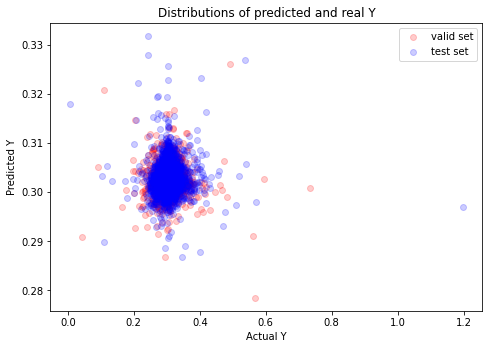

In [7]:
#####【1】Direct Modling on Original Data 
model_lr = LinearRegression(copy_X=True, n_jobs=100)
model_lr.fit(X_train_5_norm, y_train_5_norm)
get_cv_scores(model_lr, X_train_5_norm, y_train_5_norm)
evaluate_valid(model_lr, X_valid_5_norm, y_valid_5_norm, X_test_5_norm, y_test_5_norm)
print('Independent term in the linear model: ', model_lr.intercept_)
print('Estimated coefficients in the linear regression: ', model_lr.coef_)

CV Mean of R2:  -0.0015294093390221919
CV STD of R2:  0.01125642869816964
Validation MAE: 0.010431111874573464
Validation R2: -0.0092720854976851
Test MAE: 0.009266608102802514
Test R2: -0.004234528764248902
Independent term in the linear model:  [0.34306619]
Estimated coefficients in the linear regression:  [[ 1.15396989e-04 -3.80589308e-04 -6.85560753e-04 -1.80948010e-04
   1.04806947e-03 -1.78024092e-02  3.39170267e-02  2.52379907e-02
  -2.75026649e-02  1.06233895e-02  4.38870341e+09 -2.30498263e-02
   6.53584105e-02  1.81351185e-02 -2.73752566e-02 -5.21567775e-03
  -4.38204621e+09 -2.48816817e-02  9.01133928e-02  2.12005543e-03
  -3.84173274e-02 -6.42563568e-02  4.44435406e+09 -6.36375521e-03
   6.54531962e-02  1.45144195e-02 -1.15386295e-01 -9.23323678e-02
  -4.45101126e+09]]


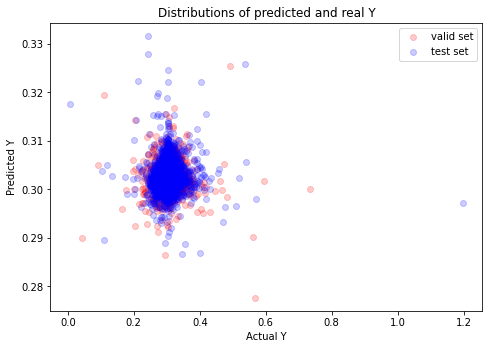

In [8]:
#####【2】Modeling after Dropping the cos/sin-transformed columns
X_train_5_drop, X_valid_5_drop, X_test_5_drop = drop_cos_sin(X_train_5, X_valid_5, X_test_5)
X_train_5_drop, X_valid_5_drop, X_test_5_drop = min_max_norm(X_train_5_drop, X_valid_5_drop, X_test_5_drop)

model_lr = LinearRegression(copy_X=True, n_jobs=100)
model_lr.fit(X_train_5_drop, y_train_5_norm)
get_cv_scores(model_lr, X_train_5_drop, y_train_5_norm)
evaluate_valid(model_lr, X_valid_5_drop, y_valid_5_norm, X_test_5_drop, y_test_5_norm)
print('Independent term in the linear model: ', model_lr.intercept_)
print('Estimated coefficients in the linear regression: ', model_lr.coef_)

CV Mean of R2:  -0.0011688204228584853
CV STD of R2:  0.011023424492587568
Validation MAE: 0.010432997508833515
Validation R2: -0.009840975484630254
Test MAE: 0.009265287286828034
Test R2: -0.0044684845822882124
Independent term in the linear model:  [0.33964351]
Estimated coefficients in the linear regression:  [[-1.73866551e-02  3.40537737e-02  2.51308508e-02 -2.76009746e-02
   1.17379380e-02 -3.40323996e-06 -2.26592961e-02  6.51998516e-02
   1.80566832e-02 -2.73647035e-02 -3.41594819e-03 -3.40323996e-06
  -2.44782944e-02  8.98511330e-02  2.16527943e-03 -3.82638070e-02
  -6.23867116e-02 -3.40323996e-06 -6.17759280e-03  6.53716513e-02
   1.45555429e-02 -1.15064021e-01 -9.09997125e-02 -3.40323996e-06]]


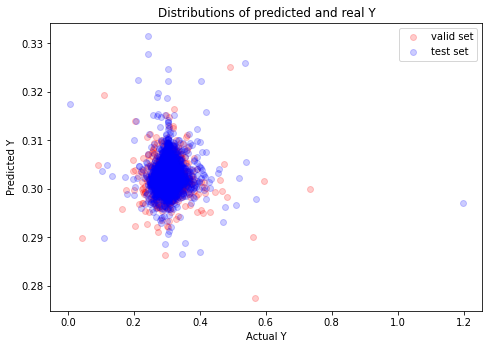

In [9]:
#####【3】Modeling after Dropping the first half of all columns, keeping only the trading data
X_train_5_half, X_valid_5_half, X_test_5_half = drop_first_half(X_train_5, X_valid_5, X_test_5)
X_train_5_half, X_valid_5_half, X_test_5_half = min_max_norm(X_train_5_half, X_valid_5_half, X_test_5_half)

model_lr = LinearRegression(copy_X=True, n_jobs=100)
model_lr.fit(X_train_5_half, y_train_5_norm)
get_cv_scores(model_lr, X_train_5_half, y_train_5_norm)
evaluate_valid(model_lr, X_valid_5_half, y_valid_5_norm, X_test_5_half, y_test_5_norm)
print('Independent term in the linear model: ', model_lr.intercept_)
print('Estimated coefficients in the linear regression: ', model_lr.coef_)

# <b> 3. Plynomial Regression</b>

In [10]:
##### Polynomial (Degree=2) Transformation of X_train/valid/test
polynomial_features= PolynomialFeatures(degree=2)
X_train_5_poly = polynomial_features.fit_transform(X_train_5)
X_valid_5_poly = polynomial_features.fit_transform(X_valid_5)
X_test_5_poly = polynomial_features.fit_transform(X_test_5)

CV Mean of R2:  -3.511113187882389e+21
CV STD of R2:  6.469575871038611e+21
Validation MAE: 2.789553597204562
Validation R2: -0.2168227041260773
Test MAE: 2.467370614135925
Test R2: -0.07223989643642659


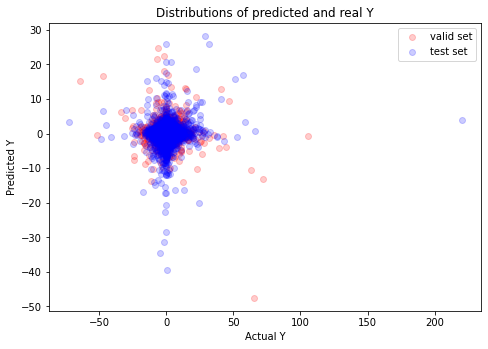

In [11]:
##### Model Fitting & Results
model_lr = LinearRegression(normalize=True, copy_X=True, n_jobs=100)
model_lr.fit(X_train_5_poly, y_train_5)
get_cv_scores(model_lr, X_train_5_poly, y_train_5)
evaluate_valid(model_lr, X_valid_5_poly, y_valid_5, X_test_5_poly, y_test_5)

In [12]:
##### Polynomial (Degree=3) Transformation of X_train/valid/test
polynomial_features= PolynomialFeatures(degree=3)
X_train_5_poly = polynomial_features.fit_transform(X_train_5)
X_valid_5_poly = polynomial_features.fit_transform(X_valid_5)
X_test_5_poly = polynomial_features.fit_transform(X_test_5)

CV Mean of R2:  -3.0946055631103586e+23
CV STD of R2:  5.2198700229410427e+23
Validation MAE: 4.525759840179881
Validation R2: -7.758518936041334
Test MAE: 4.262350287786692
Test R2: -8.665790077256661


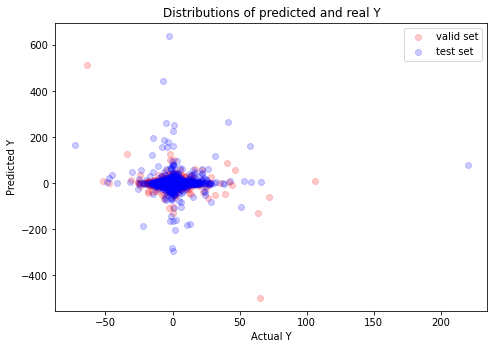

In [13]:
##### Model Fitting & Results (took Colab Pro+ 40min to run....)
model_lr = LinearRegression(normalize=True, copy_X=True, n_jobs=100)
model_lr.fit(X_train_5_poly, y_train_5)
get_cv_scores(model_lr, X_train_5_poly, y_train_5)
evaluate_valid(model_lr, X_valid_5_poly, y_valid_5, X_test_5_poly, y_test_5)

In [ ]:
############# 【!】Take ages to run....【!】
##### Build a pipeline
def PolynomialRegression(degree = 2, ** kwargs):
   return make_pipeline(PolynomialFeatures(degree), LinearRegression( ** kwargs))

##### Define the GridSearchCV parameters
param_grid = {'polynomialfeatures__degree': [2,3],
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]
              }
grid = GridSearchCV(PolynomialRegression(), param_grid, cv = 5)
grid.fit(X_train_5, y_train_5)

##### Get the best parameters from our model
model_GS = grid.best_estimator_
model_GS

# Pipeline(memory = None,
#    steps = [('polynomialfeatures', 
#              PolynomialFeatures(degree = 4, include_bias = True, interaction_only = False)), 
#             ('linearregression', LinearRegression(copy_X = True, fit_intercept = True, n_jobs = 1, normalize = False))])